In [109]:
import sys
import json
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

In [142]:
results_folder = './results/zhang/'
sampleID = '151507'
n_hat = 5
a_y = 20
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map_{sampleID}_{n_hat}_{a_y}'

In [3]:
import csv #import to use the csv module
a = []
with open('./data/scRNA/unnormalized_rna_filtered.csv', mode="r") as csv_file: #"r" represents the read mode
    reader = csv.reader(csv_file) #this is the reader object

    for item in reader:
    # you have to loop through the document to get each data
        a.append(int(item[0]))   

In [20]:
adata_X = np.array(a)

In [121]:
adata_X = adata_X.reshape((10581,36601))

In [122]:
adata_ref = anndata.AnnData(adata_X)

C:\Users\xiong\AppData\Local\Temp\ipykernel_31424\3408600833.py:1: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_ref = anndata.AnnData(adata_X)


In [114]:
cell_inf = pd.read_csv('./data/scRNA/cell_type_annotation.csv',header=None)

In [115]:
gene_inf = pd.read_csv('./data/scRNA/genes_filtered.csv',header=None)

In [123]:
adata_ref.obs['Sample'] = 'onebatch'
adata_ref.obs.index = pd.Categorical(cell_inf[0])
adata_ref.obs['Subset'] = pd.Categorical(cell_inf[1])

In [124]:
adata_ref.var = pd.DataFrame(gene_inf[0])
adata_ref.var.rename(columns = {0:"Gene Name"}, inplace="True")

In [125]:
adata_ref.var.index = adata_ref.var["Gene Name"]

In [126]:
del adata_ref.var["Gene Name"]

c:\Users\xiong\anaconda3\envs\cell0\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


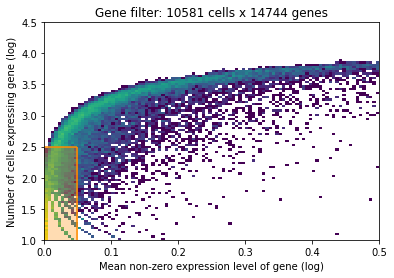

c:\Users\xiong\anaconda3\envs\cell0\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [127]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [89]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset',
                       )

In [90]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 14744 │
│         n_cells          │ 10581 │
│         n_batch          │   1   │
│         n_labels         │   7   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │  onebatch  │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                  labels State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │   Astro    │          0          │
│                     │    Endo    │          1          │
│                     │    Exc     │          2          │
│                     │    Inh     │          3          │
│                     │   Micro    │          4          │
│                     │    OPC     │          5          │
│                     │   Oligo    │          6          │
└─────────────────────┴────────────┴─────────────────────┘

In [91]:
mod.train(max_epochs=250, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\xiong\anaconda3\envs\cell0\lib\site-packages\pytorch_lightning-1.6.5-py3.9.egg\pytorch_lightning\trainer\configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\xiong\anaconda3\envs\cell0\lib\site-packages\pytorch_lightning-1.6.5-py3.9.egg\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 250/250: 100%|██████████| 250/250 [02:21<00:00,  1.77it/s, v_num=1, elbo_train=9.75e+7]


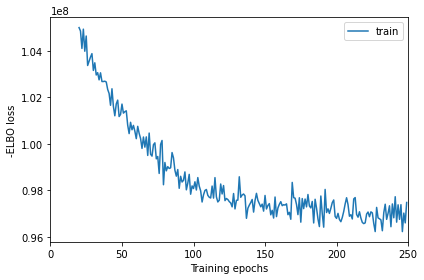

In [92]:
mod.plot_history(20)

In [93]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)

Sampling global variables, sample: 100%|██████████| 999/999 [00:09<00:00, 107.62it/s]


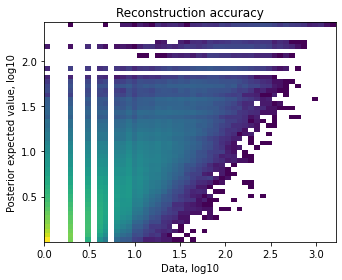

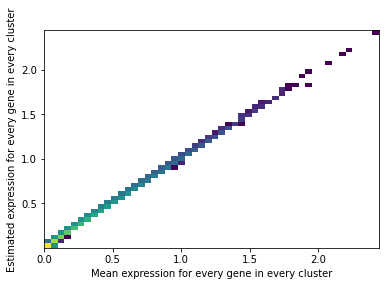

In [94]:
mod.plot_QC()

In [143]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
#mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [144]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.T

Gene Name,AL627309.5,LINC01409,LINC01128,NOC2L,HES4,ISG15,AGRN,C1orf159,SDF4,UBE2J2,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,AL592183.1,AC240274.1
Astro,0.012545,0.020118,0.051460,0.018230,0.018780,0.027318,0.026821,0.102767,0.048525,0.031673,...,0.054610,0.308620,1.002332,0.307945,0.086879,0.690792,0.226902,0.336376,0.070337,0.043255
Endo,0.009685,0.066148,0.066009,0.038444,0.283210,0.095384,0.152800,0.098145,0.037942,0.075512,...,0.241456,0.733857,1.739982,0.563946,0.233869,1.221411,0.582215,0.623748,0.190303,0.032337
Exc,0.056690,0.346810,0.344608,0.130164,0.063044,0.021441,0.191387,0.793924,0.167425,0.186270,...,0.097813,0.387557,0.964250,0.338330,0.115123,0.649395,0.233769,0.334056,0.514954,0.033344
Inh,0.024747,0.152778,0.147571,0.078873,0.056669,0.038921,0.035056,0.393842,0.132009,0.130363,...,0.102180,0.392562,0.922824,0.299214,0.106907,0.608013,0.224730,0.313212,0.435366,0.044418
Micro,0.012819,0.026701,0.019630,0.010168,0.009009,0.001125,0.007377,0.028790,0.008662,0.018916,...,0.107587,0.310940,0.809791,0.287722,0.084595,0.497967,0.229465,0.284084,0.067448,0.007456
OPC,0.005393,0.048222,0.033067,0.032701,0.023471,0.011454,0.029512,0.073514,0.021029,0.048276,...,0.111956,0.384524,0.870170,0.298456,0.126092,0.588645,0.270680,0.309897,0.206801,0.014039
Oligo,0.003671,0.010119,0.020111,0.004467,0.004464,0.007514,0.010324,0.068305,0.010063,0.021040,...,0.093726,0.343043,0.816674,0.239411,0.095303,0.616788,0.215472,0.281838,0.103401,0.004617


In [145]:
adata_vis = sc.read_10x_h5(f'./data/{sampleID}_filtered_feature_bc_matrix.h5')
adata_vis.var_names_make_unique()
adata_vis.obs['sample'] = "HumanPilot10x"

c:\Users\xiong\anaconda3\envs\cell0\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [146]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [147]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=n_hat,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=a_y
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 13805 │
│         n_cells          │ 4226  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ HumanPilot10x │          0          │
└─────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\xiong\anaconda3\envs\cell0\lib\site-packages\pytorch_lightning-1.6.5-py3.9.egg\pytorch_lightning\trainer\configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\xiong\anaconda3\envs\cell0\lib\site-packages\pytorch_lightning-1.6.5-py3.9.egg\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 30000/30000: 100%|██████████| 30000/30000 [51:31<00:00,  9.70it/s, v_num=1, elbo_train=1.6e+7]  


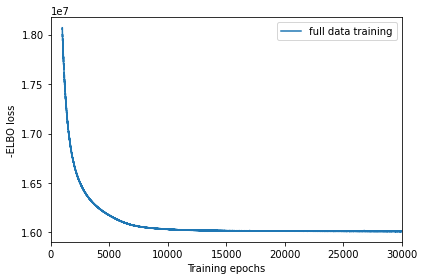

In [148]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [149]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)

Sampling global variables, sample: 100%|██████████| 999/999 [00:19<00:00, 51.78it/s]


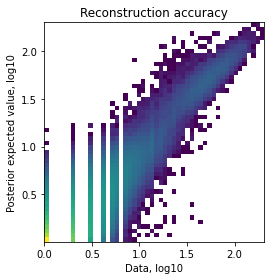

In [150]:
mod.plot_QC()

In [151]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
#mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

In [152]:
hire = plt.imread(f'./data/{sampleID}_tissue_hires_image.png')
lowre = plt.imread(f'./data/{sampleID}_tissue_lowres_image.png')
adata_vis.uns['spatial'] = dict()
adata_vis.uns['spatial']['HumanPilot10x'] = dict()
adata_vis.uns['spatial']['HumanPilot10x']['images'] = dict()
adata_vis.uns['spatial']['HumanPilot10x']['images'] = {'hires':hire, 'lowres':lowre}

In [153]:
f = open('./data/151674_scalefactors_json.json')
scalefactors = json.load(f)
f.close()
adata_vis.uns['spatial']['HumanPilot10x']['scalefactors'] = scalefactors

In [154]:
columns = ['Name', 'n0', 'n1', 'n2', 'c1', 'c2']
txt_data = pd.read_csv(f"./data/{sampleID}_tissue_positions_list.txt", index_col=False, names=columns)
obs_index = pd.DataFrame(adata_vis.obs.index)
obs_index.columns = ['Name']
merge_data = txt_data.merge(obs_index, on='Name',how='right')
_spatial = np.stack((np.array(merge_data['c2']),np.array(merge_data['c1'])), axis = -1)
adata_vis.obsm['spatial'] = _spatial

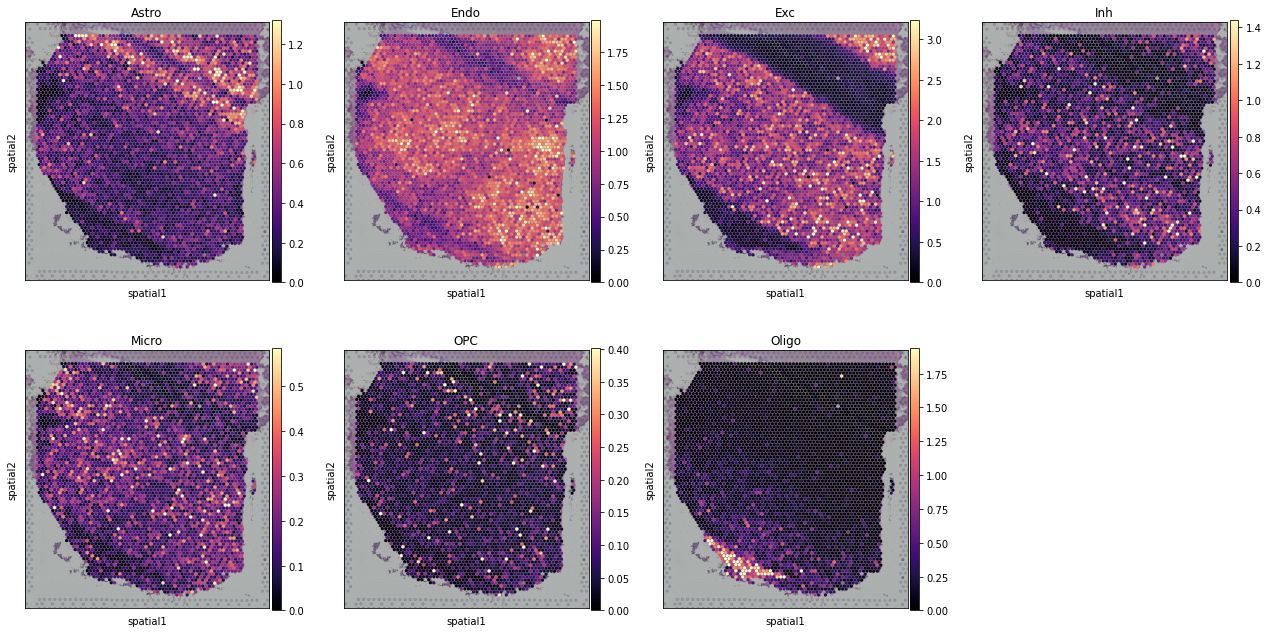

In [155]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'HumanPilot10x')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  color=['Astro','Endo','Exc','Inh','Micro','OPC','Oligo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )